In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import torch
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision.transforms import transforms as tfm
from tqdm import tqdm

from lib.data.baltech_101 import Baltech101
from lib.utils.dataset_features import get_dataset_features
from lib.utils.feature_hooks import add_feature_hooks
from lib.utils.image_tools import show_ims
from lib.utils.model_device import get_model_device
from lib.utils.run_name import get_clf_run_name

# 3. Convolutional Neural Networks

A Convolutional Neural Network (CNN) is a deep learning technique that uses the concept of *local connectivity*. The idea is that in a lot of datasets, tensor elements that are close to each other, are likely to be a lot more connected than tensor elements that are further away. For example, the elements in an image tensor represent pixels. Pixels that are spatially close to each other are likely to represent the same part of the image, while pixels that are further away can represent different parts.

CNNs are explained in [this Stanford tutorial](http://ufldl.stanford.edu/tutorial/supervised/ConvolutionalNeuralNetwork/).

## 3.1 Classifying MNIST with a CNN

In this section, we are going to train a basic CNN on the MNIST dataset. Let's first take a look at how we can implement a CNN in PyTorch.

### 3.1.1 Implementing a Simple CNN

You can use [`nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) to create a single convolutional layer in PyTorch. Some of its interesting arguments are:

- `in_channels`: the number of channels in the input tensor. When the input is an RGB image, this is `3`. For a single-channel gray scale image, this is `1`. Note that each convolution filter in the layer will have this amount of channels as the filter needs to cover the *entire depth* of the input.
- `out_channels`: the number of convolution filters that this layer has. Each filter will produce a new channel in the output. As such, if another `nn.Conv2d()` takes the output of this layer as its input, that layer's `in_channels` should be set to this layer's `out_channels`.
- `kernel_size`: the height and width of the convolution filters. If this is a single integer, it will be used for both the height and the width (i.e., square filters).
- `stride`: the stride (step size) of the convolution operation (default: `1`).
- `padding`: the amount of padding to add to the input (default: `0`). *Padding* is a border of black pixels that is added around the input image. This allows more of the convolution operation to be applied to the pixels at the edge of the image and can avoid the output resolution to shrink w.r.t. the input resolution. When `padding` is set to `1`, a black border of a single pixel wide will be added at each image edge.

Apart from convolutional layers, a CNN also typically contains *pooling layers*. Similar to conv layers, a pooling layer uses a sliding window to operate on its input. Instead of computing an inner product, however, the pooling window **aggregates** the underlying values, e.g., by computing the *maximum* or *average* value. For example:

- [`nn.MaxPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) applies max pooling.
- [`nn.AvgPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html) applies average pooling.

Just like `nn.Conv2d()`, these pooling layers take `kernel_size`, `stride` (default: `1`) and `padding` (default: `0`) as an argument.

The pooling layers also have *adaptive* equivalents: [`nn.AdaptiveMaxPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveMaxPool2d.html) and [`nn.AdaptiveAvgPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html). These adaptive layers produce an **output of a fixed, predefined width and height no matter the input size** (the number of channels stays the same). This is in contrast with regular pooling layers, where the output size depends on the input size.

**Copy-paste the following CNN implementation in the cell below and complete it.** Note that we did not always specify the number of input channels and input features, as you should be able to infer these from the previous layers.

```python
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = # conv with 12 5x5 conv filters with 1 input channel
        self.relu1 = # ReLU activation
        self.pool1 = # max pooling with kernel size 2 and stride 2

        self.conv2 = # conv with 24 5x5 conv filters
        self.relu2 = # ReLU activation
        self.pool2 = # adaptive avg pool with output width and height 1

        # This flattens the output of pool2 to N x 24 (N = batch size)
        self.flatten = nn.Flatten(
            start_dim=1
        )
        self.fc = # fully-connected layer that outputs 10 values

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flatten(x)
        x = self.fc(x)

        return x
```

In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels= 1, out_channels= 12, kernel_size= 5) # conv with 12 5x5 conv filters with 1 input channel
        self.relu1 = nn.ReLU() # ReLU activation
        self.pool1 = nn.MaxPool2d(kernel_size= 2 , stride= 2) # max pooling with kernel size 2 and stride 2

        self.conv2 = nn.Conv2d(in_channels= 12, out_channels= 24, kernel_size= 5) # conv with 24 5x5 conv filters
        self.relu2 = nn.ReLU() # ReLU activation
        self.pool2 = nn.AdaptiveAvgPool2d(output_size=1) # adaptive avg pool with output width and height 1

        # This flattens the output of pool2 to N x 24 (N = batch size)
        self.flatten = nn.Flatten(
            start_dim=1
        )
        self.fc = nn.Linear(in_features=24, out_features=10)# fully-connected layer that outputs 10 values

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flatten(x)
        x = self.fc(x)

        return x

For each input, your CNN returns 10 values. These values will correspond to the 10 classes in the MNIST dataset.

### 3.1.2 Preparing the Data for Mini-Batch Training

In the previous notebook, we passed *the entire* MNIST dataset in batch through the model during training. This is possible because each MNIST image consists of only a single $28\times 28$ channel and there are *only* 60 000 training images in the dataset. In real-world computer vision applications, the images are typically much larger in size and number, making it infeasible or impossible to train with batches containing the entire training dataset.

Instead, it is customary to train CNNs on **mini-batches**. Each such mini-batch contains only a fraction of all samples available in the training dataset. After each forward pass with a mini-batch, the parameters of the model are updated. When the model has seen all training samples, a single epoch is done. Before each of the next epoch(s), the data can be shuffled such that mini-batches always contain other combinations of samples.

Before diving into mini-batch training with PyTorch, let's first learn about PyTorch **[`Dataset`s](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)**. A PyTorch `Dataset` contains all the information that you need to get a sample from a certain dataset. The `MNIST` class, for example, is a `Dataset`:

In [3]:
mnist_train = MNIST(
    root='data',
    download=True,
    train=True,
)

isinstance(mnist_train, Dataset)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



True

Since `mnist_train` is an instance of a PyTorch `Dataset`, it is **guaranteed** that `mnist_train` supports the following two operations:

1. `len(mnist_train)` returns the total number of samples in the dataset;
2. `mnist_train[i]` returns the data sample at index `i`, with `i >= 0` and `i < len(mnist_train)`.

Indeed, `mnist_train` supports these operations in an exemplary way:

In [4]:
len(mnist_train)

60000

In [5]:
i = 100
mnist_train[i]

(<PIL.Image.Image image mode=L size=28x28>, 5)

As you can see, choosing a random sample from `mnist_train` returns a tuple containining a `PIL.Image` and the label of the corresponding image. Unfortunately, we cannot use a `PIL.Image` as input for our model. The `PIL.Image` must be transformed into a PyTorch `Tensor`. We can **pass in an argument `transform` to the `MNIST` constructor** to take care of this:

In [6]:
mnist_train = MNIST(
    root='data',
    download=True,
    train=True,
    transform=tfm.ToTensor()  # This transforms the PIL.Image into a Tensor when sampling
)

Indeed, now `mnist_train[i]` returns a PyTorch `Tensor`! 🙌 (along with the corresponding label)

> Note that you can pass in much more advanced transforms as well. More specifically, if you want to perform *data augmentation*, you typically pass in a chain of transforms with [`Compose()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html). For more information, see [here](https://pytorch.org/vision/stable/transforms.html).

In [7]:
img, label = mnist_train[i]
type(img)

torch.Tensor

Now, how can we use a `Dataset` to create mini-batches for training? For that, we need a PyTorch [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). A `DataLoader` samples from the given dataset and combines the samples into batches of a predefined batch size. Let's create a `DataLoader` for `mnist_train`:

In [8]:
dl_train = DataLoader(
    mnist_train,      # The dataset
    batch_size=4096,  # How many samples should be inside a single batch?
    shuffle=True,     # If True, compose the batches randomly
    num_workers=4,    # The number of parallel jobs to use during data loading
    drop_last=False,  # If True, drop the last incomplete batch (if the dataset size is not divisible by the batch size).
)

We can **put `dl_train` in a `for` loop** to iterate over all batches of a single epoch:

In [9]:
for x_train, y_train in dl_train:
    print(x_train.shape)

torch.Size([4096, 1, 28, 28])
torch.Size([4096, 1, 28, 28])
torch.Size([4096, 1, 28, 28])
torch.Size([4096, 1, 28, 28])
torch.Size([4096, 1, 28, 28])
torch.Size([4096, 1, 28, 28])
torch.Size([4096, 1, 28, 28])
torch.Size([4096, 1, 28, 28])
torch.Size([4096, 1, 28, 28])
torch.Size([4096, 1, 28, 28])
torch.Size([4096, 1, 28, 28])
torch.Size([4096, 1, 28, 28])
torch.Size([4096, 1, 28, 28])
torch.Size([4096, 1, 28, 28])
torch.Size([2656, 1, 28, 28])


As you can see, we get 15 batches: 14 batches with 4096 samples and 1 batch with 2656 samples, totaling to 60 000 samples.

Let's create a data loader for the validation data as well. It is best to set `shuffle=False` so that each validation loop uses the exact same batches. For simplicity, we use the entire dataset size as the batch size for validation here.

In [10]:
mnist_val = MNIST(
    root='data',
    download=True,
    train=False,
    transform=tfm.ToTensor()
)

dl_val = DataLoader(
    mnist_val,
    batch_size=len(mnist_val),
    shuffle=False,
    num_workers=4,
)

### 3.1.3 Defining the Training Loop

Now that we have our model and data ready, we can define our training loop! We have already implemented it below. The implementation is very similar to the previous training loops we have seen. There are a couple of notable differences, however:

- There are *two nested `for` loops* that iterate over the dataloaders;
- We keep track of a *global training and validation iteration step* to have unique values for the horizontal axes in TensorBoard;
- We move the batches to the compute device (GPU) in the training script itself.

In [11]:
def train_classifier(model, dl_train, dl_val, optimizer, loss_fn, num_epochs, log_root):
    """
    Train a classifier.

    Args:
        model: The classification model.
        dl_train: The training data loader.
        dl_val: The validation data loader.
        optimizer: The optimizer.
        loss_fn: The loss function.
        num_epochs: The number of epochs.
        log_root: The root directory of the TensorBoard logs.
    """
    # Get compute device of model
    device = get_model_device(model)

    # Create SummaryWriter with a meaningful name
    run_name = get_clf_run_name(model, optimizer, dl_train)
    writer = SummaryWriter(log_dir=f'{log_root}/{run_name}')

    # Global training and validation iteration step
    train_step = 0
    val_step = 0

    # Iterate over the epochs
    for epoch in tqdm(range(num_epochs)):
        # Put model in training mode (see Sec. 3.2.1)
        model.train()

        # Iterate over the training mini-batches
        for x_train, y_train in dl_train:
            x_train = x_train.to(device)
            y_train = y_train.to(device)

            y_pred = model(x_train)

            # Compute loss
            loss = loss_fn(y_pred, y_train)

            # Backpropagate + optimizer step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Log loss
            writer.add_scalar(f"{loss_fn.__class__.__name__}/Train", loss, train_step)
            writer.add_scalar("Epoch/Train", epoch, train_step)

            train_step += 1

        # Put model in evaluation mode (see Sec. 3.2.1)
        model.eval()

        # Iterate over the validation mini-batches
        for x_val, y_val in dl_val:
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            with torch.no_grad():
                y_pred = model(x_val)

                # Compute loss
                loss = loss_fn(y_pred, y_val)

                # Compute accuracy
                acc = (y_val == y_pred.argmax(dim=1)).float().mean()

            # Log validation loss and accuracy
            writer.add_scalar(f"{loss_fn.__class__.__name__}/Val", loss, val_step)
            writer.add_scalar("Accuracy/Val", acc, val_step)
            writer.add_scalar("Epoch/Val", epoch, val_step)

            val_step += 1

### 3.1.4 Running the Training

Time to train our home-grown CNN! 🪴

- Create a CNN called `simple_cnn` by instantiating your `SimpleCNN` class;
- Create a suitable optimizer;
- Define a suitable loss function for training classification;
- Also redefine the training data loader in the cell below, so that you can easily play with the batch size. Keep the validation batch size fixed, though, no matter what training batch size you choose;
- Don't forget to move your model to the correct compute device.

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
# Initialize CNN and move to device
simple_cnn = SimpleCNN()
simple_cnn = simple_cnn.to(device)

# Set optimizer
optimizer = optim.Adam(
    params= simple_cnn.parameters(),
    lr= 0.001
)

# Set a loss function
loss_fn = nn.CrossEntropyLoss()

# Define the train dataloader
dl_train = DataLoader(
    mnist_train,
    batch_size=32,
    shuffle=False,
    num_workers=2,
)

# Train
train_classifier(
    model= simple_cnn,
    dl_train= dl_train,
    dl_val= dl_val,
    optimizer= optimizer,
    loss_fn= loss_fn,
    num_epochs= 50,
    log_root= 'runs_cnn_32'
)

  0%|          | 0/50 [00:51<?, ?it/s]


KeyboardInterrupt: 

You can use the following cell to visualize the confusion matrix.

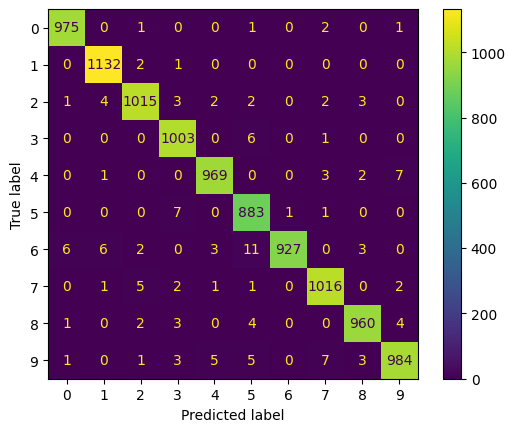

In [17]:
with torch.no_grad():
    # Compute class logits of each sample
    y_pred = torch.cat([
        simple_cnn(x_val.to(device))
        for x_val, _ in dl_val
    ])

# For each sample, get the class with the highest logit
y_pred = y_pred.argmax(dim=1).cpu()

# Get the ground-truth classes
y_true = mnist_val.targets

# Compute and show the confusion matrix
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

### 3.1.5 Exercise

- Try out different values for the training batch size. What do you notice? Briefly discuss your results.

### Batch size 128

In [18]:
# Initialize CNN and move to device
simple_cnn = SimpleCNN()
simple_cnn = simple_cnn.to(device)

# Set optimizer
optimizer = optim.Adam(
    params= simple_cnn.parameters(),
    lr= 0.001
)

# Set a loss function
loss_fn = nn.CrossEntropyLoss()

# Define the train dataloader
dl_train = DataLoader(
    mnist_train,
    batch_size=128,
    shuffle=False,
    num_workers=2,
)

# Train
train_classifier(
    model= simple_cnn,
    dl_train= dl_train,
    dl_val= dl_val,
    optimizer= optimizer,
    loss_fn= loss_fn,
    num_epochs= 50,
    log_root= 'runs_cnn_128'
)

100%|██████████| 30/30 [01:59<00:00,  3.99s/it]


### Batch size 512

In [19]:
# Initialize CNN and move to device
simple_cnn = SimpleCNN()
simple_cnn = simple_cnn.to(device)

# Set optimizer
optimizer = optim.Adam(
    params= simple_cnn.parameters(),
    lr= 0.001
)

# Set a loss function
loss_fn = nn.CrossEntropyLoss()

# Define the train dataloader
dl_train = DataLoader(
    mnist_train,
    batch_size=512,
    shuffle=False,
    num_workers=2,
)

# Train
train_classifier(
    model= simple_cnn,
    dl_train= dl_train,
    dl_val= dl_val,
    optimizer= optimizer,
    loss_fn= loss_fn,
    num_epochs= 50,
    log_root= 'runs_cnn_512'
)

100%|██████████| 30/30 [01:45<00:00,  3.50s/it]


## 3.2 Using a Pre-Trained CNN as Deep Feature Extractor

In the "old" days of computer vision, researchers put a lot of effort in developing hand-crafted algorithms that could extract descriptive *features* from an image. Typical examples of such algorithms are SIFT, SURF and HOG. These general features can be used for a down-stream task like classification, which would be trained with a machine learning algorithm like SVM, taking the features as an input.

Since the advent of deep learning, CNNs have shown impressive capabilities as general feature extractors, often outperforming hand-crafted features by a large margin. An easy way to leverage the power of CNNs, without investing time and effort into training, is to use a *pre-trained CNN* as a feature extractor. This is a CNN that is already trained on a very large dataset.

### 3.2.1 Loading Pre-Trained Weights

The `torchvision` library of PyTorch [contains many popular neural network architectures](https://pytorch.org/vision/stable/models.html) with the option to load pre-trained weights. Below, we import a ResNet-50 model ([He et al., 2015](https://arxiv.org/abs/1512.03385)) and load in weights that were obtained after training the model on ImageNet1K ([Deng et al., 2009](https://ieeexplore-ieee-org.kuleuven.e-bronnen.be/document/5206848)).

We also call [`eval()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.eval) on the model. This sets the model in *evaluation mode*, which is important because the [BatchNorm](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html?highlight=batchnorm#torch.nn.BatchNorm2d) layers of ResNet have a different behaviour in training and evaluation mode. Similarly, calling `train()` on a model switches the model back to training mode. **From now on, make it a habbit to always call `eval()` before evaluating your model** (so, also before your validation loop) **and `train()` before training the model.** 

In [15]:
from torchvision.models import resnet50, ResNet50_Weights

rn50_weights = ResNet50_Weights.DEFAULT

# Create a ResNet-50 with the pre-trained weights
rn50 = resnet50(weights=rn50_weights)

# Set model in evaluation mode
rn50 = rn50.eval()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /data/leuven/351/vsc35150/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

If you print out the ResNet-50 model architecture, you'll see that the model is much more complex than our `SimpleCNN`. Training such a big model from scratch requires large amounts of data. With the pre-trained ImageNet weights, however, we will see that our model is already very useful!

In [16]:
rn50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 3.2.2 Investigating CNN Weights

The layers at the beginning of the network capture basic image features, such as edges and blobs. To see this, let's visualize the network filter weights from the first convolutional layer `conv1`. This can help build up an intuition as to why the features extracted from CNNs work so well for image recognition tasks. See also ([Zeiler and Fergus, 2013](https://arxiv.org/abs/1311.2901)).

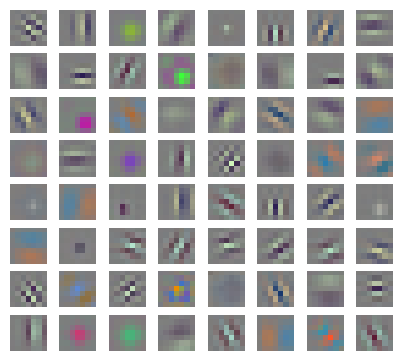

In [17]:
# Copy the conv1 weights and detach them from autograd
conv1_weights = torch.clone(rn50.conv1.weight).detach()

# Scale the weights in range [0, 1] for visualization purposes
conv1_weights -= conv1_weights.min()
conv1_weights /= conv1_weights.max()

# Change order of channels for visualization purposes
conv1_weights = conv1_weights.permute(0, 3, 2, 1)

# Visualize conv1 weights
show_ims(conv1_weights, columns=8, figsize=(5, 5))

Notice how the first layer of the network has learned filters for capturing blob and edge features. These "primitive" features are then processed by deeper network layers, which combine the early features to form higher level image features. These higher level features are better suited for recognition tasks because they combine all the primitive features into a richer image representation ([Donahue et al., 2013](https://arxiv.org/abs/1310.1531)).

### 3.2.3 Preparing the Data

For this example, we will use `Baltech101`, a balanced version of the [Caltech 101 dataset](https://pytorch.org/vision/stable/generated/torchvision.datasets.Caltech101.html). This is a classification dataset containing 101 classes with 31 images per class. By passing in `download=True`, the dataset will be downloaded if necessary.

In [18]:
baltech_101 = Baltech101(
    root='data',    # Root data folder
    download=True,  # Download if necessary
)

0it [00:00, ?it/s]

Extracting data/caltech101/101_ObjectCategories.tar.gz to data/caltech101


0it [00:00, ?it/s]

Extracting data/caltech101/Annotations.tar to data/caltech101


Let's have a look at some images in the dataset. The corresponding class label is shown above each image.

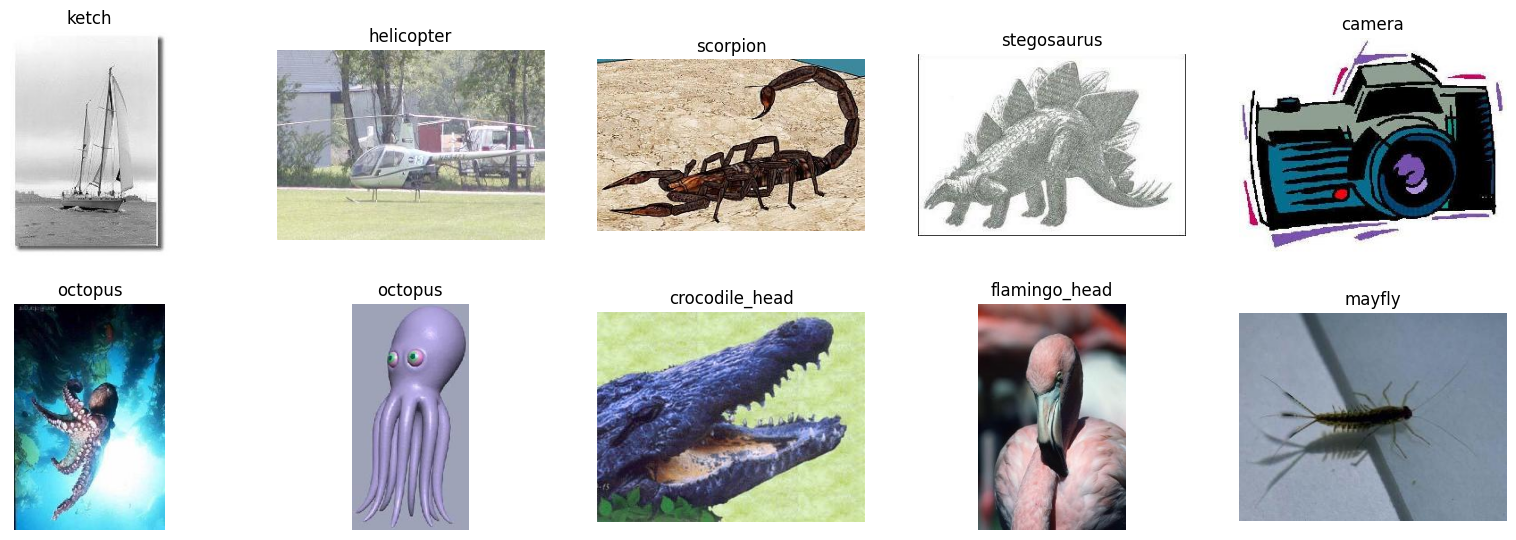

In [19]:
N = 10  # The number of samples to show

# Generate N different numbers between 0 and len(baltech_101)
idxs = torch.randperm(len(baltech_101))[:N]

ims = []
labels = []

# Iterate over the sample indices
for i in idxs:
    # Select the sample at index i
    im, label_idx = baltech_101[i]

    # Map the label number to a human-readable category name
    label = baltech_101.categories[label_idx]

    ims.append(im)
    labels.append(label)


show_ims(ims, title=labels)

To make our dataset suitable for use with our pre-trained ResNet-50 model, we should **apply the same transforms as were used during pre-training**. PyTorch makes this very easy for us. The `rn50_weights` object we used to initialize the model has an attribute `transforms()` that contains the transforms that were used. Let's create a new `baltech_101` object that will apply these transforms before returning a sample.

In [20]:
baltech_101_tfm = Baltech101(
    root='data',
    download=True,
    transform=rn50_weights.transforms()  # Add transforms used during pre-training
)

Files already downloaded and verified


### 3.2.4 Obtaining Intermediate Features

The ResNet-50 model outputs 1000 numbers that correspond to the 1000 classes in ImageNet. These aren't very useful for us. Instead, we want to use the model as a *feature extractor* and thus want to obtain an intemediary feature outputted by one of the model's layers.

For this, we will attach [*hooks*](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_forward_hook) to the layers of the ResNet-50 model. These hooks are functions that will be called each time a tensor is passed through the corresponding layer and allow us to catch the output of that layer.

We have created a function for you that attaches all these hooks so you don't need to worry about it. It returns a dictionary `features` that stores each layer's most recent output, using the layer's name as key.

In [21]:
# Attach the hooks to our model
features = add_feature_hooks(rn50)

When we pass an image through the network now, we'll be able to inspect the features outputted by any layer of our `rn50` model.

In [22]:
img_idx = 123  # Pick a random image to pass through the model

img, label = baltech_101_tfm[img_idx]

with torch.no_grad():
    rn50(img[None, ...])  # None adds a batch dimension, which is expected by our model

For example, let's check out the output of layer `conv1` for the given input.

In [23]:
conv1_output = features['conv1']

The output is a tensor containing **1 feature map with 64 channels and a height and width of 112**:

In [24]:
conv1_output.shape

torch.Size([1, 64, 112, 112])

We visualize the 64 channels of this feature map below.

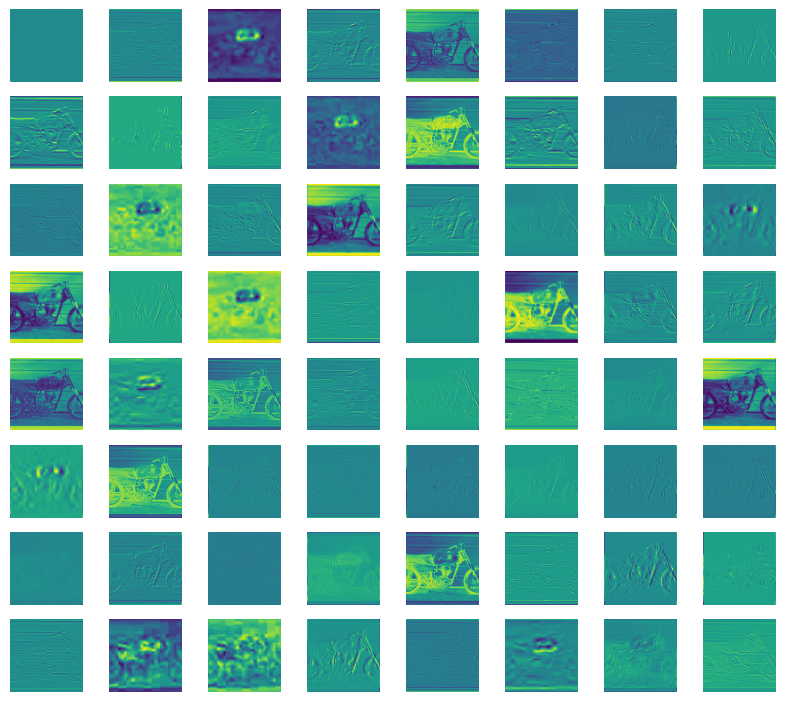

In [25]:
show_ims(features['conv1'][0], columns=8, figsize=(10, 10))

As you can see, each filter in the first convolutional layer indeed emphasizes certain kinds of edges and regions in the image.

### 3.2.5 Obtaining Deep Features for Classification Training

The features returned by the `conv1` layer are still very close to the pixel level and, as such, don't carry a lot of semantic information. These aren't very suitable for training a classifier. Instead, we need features returned by deeper levels of the network, so called *deep features*.

The `avgpool` layer, for example, is the last layer before the fully-connected layer that does the ImageNet classification. We can see that it returns a **2048-dimensional deep feature vector**.

In [26]:
features['avgpool'].shape

torch.Size([1, 2048, 1, 1])

We have implemented a function `get_dataset_features()` that collects the outputs of a certain layer of a network for an entire dataset. Below, we collect the features returned by the `avgpool` layer for the entire `Baltech101` dataset.

In [27]:
X, y = get_dataset_features(
    dataset=baltech_101_tfm,
    model=rn50.to('cuda'),
    layer_name='avgpool',
    batch_size=16,
    num_workers=4
)

# Flatten X from shape (N, 2048, 1, 1) to shape (N, 2048)
X = X.flatten(start_dim=1)

100%|██████████| 196/196 [00:35<00:00,  5.47it/s]


As you can see, `X` contains a 2048-dimensional vector for all 3131 samples in `Baltech101`.

In [28]:
X.shape

torch.Size([3131, 2048])

### 3.2.6 Training an SVM Classifier on Deep Features

Now that we have computed a deep feature vector for each sample in the `Baltech101` dataset, we can train a classifier to classify the features into their corresponding classes. To correctly evaluate our model, we will first split `X` (the features) and `y` (the labels) into train an test splits. You can use [scikit-learn's `train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function for this. Some notes on the arguments used:

- `test_size`: How much data to use for the test dataset.
- `stratify`: Passing in `y` here will ensure that classes are equally represented in the train an test dataset.
- `random_state`: This number sets the state of the random generator. A certain `random_state` will always produce the same split. If you set this to `None`, the splits will be different each time.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

There are many models that we could use for classifying the deep features: a fully-connected layer with softmax activation, a decision tree, a nearest neighbours classifier,... In this example, we will use a **Support Vector Machine (SVM)** classifier.

Scikit-learn is a Python library containing many implementations of machine learning algorithms, among which [SVM classification](https://scikit-learn.org/stable/modules/svm.html#classification). We will use [their `SVC` class](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) with a linear kernel.

In [30]:
clf = SVC(kernel='linear')

To train the SVM classifier, we simply pass the features and their corresponding labels to the method `fit()`:

In [31]:
clf.fit(X_train, y_train)

SVC(kernel='linear')

To evaluate the trained SVM, we predict the classes of the test features:

In [32]:
y_pred = clf.predict(X_test)

Now, we can compute the confusion matrix and the mean accuracy.

In [33]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Convert confusion matrix to percentages
cm = cm / cm.sum(axis=1)

# The diagonal now contains the accuracy of each class
# Compute the mean accuracy by averaging the elements on the diagonal
acc = cm.diagonal().mean()

# Print the mean accuracy
print(f'Mean accuracy: {acc*100:.2f} %')

Mean accuracy: 95.30 %


### 3.2.7 Exercise

- Use [`torch.randn()`](https://pytorch.org/docs/stable/generated/torch.randn.html) to create a random tensor that can be used as input to our ResNet-50 model. Pass the random tensor through the model and report the output shapes of all layers.
- What happens to the image's width and height as an image passes through the model? What happens to the number of channels of the input? Explain which operations cause these changes. Show how you could manually compute the output shape of `layer4`, given the shape of its input.

In [37]:
# Create random tensor
rand_tensor = torch.rand((1,3,224,224))
rand_tensor = rand_tensor.to(device)

# Pass the random tensor through the resnet
rn50(rand_tensor)

# Get the hooks
conv1_output = features['conv1']
bn1_output = features['bn1']
relu_output = features['relu']
maxpool_output = features['maxpool']
layer1_output = features['layer1']
layer2_output = features['layer2']
layer3_output = features['layer3']
layer4_output = features['layer4']
avgpool_output = features['avgpool']
fc_output = features['fc']

# Print 
print(conv1_output.shape)
print(bn1_output.shape)
print(relu_output.shape)
print(maxpool_output.shape)
print(layer1_output.shape)
print(layer2_output.shape)
print(layer3_output.shape)
print(layer4_output.shape)
print(avgpool_output.shape)
print(fc_output.shape)


torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 56, 56])
torch.Size([1, 256, 56, 56])
torch.Size([1, 512, 28, 28])
torch.Size([1, 1024, 14, 14])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 1, 1])
torch.Size([1, 1000])


# 4. Report

Write a report of maximum 4 pages (including text and figures) to discuss your answers to the exercises in section

- **1.2.2**;
- **2.3**;
- **3.1.5** and **3.2.7**.